In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge

from typing import List, Optional

# Regresia liniara

Sumar:
* Introducere (algoritmul SGD)
* generarea unui set de date (sinusoida cu zgomot)
* crearea feature-urilor pentru setul ales
* normalizarea setului de date
* calcularea functiei de loss polinomiale si a derivatei acesteia (forma analitica)
* antrenarea (minimizarea functiei de loss) folosind algoritmul SGD
* antrenarea directa folosind ecuatiile normale
* regularizarea

In cele ce urmeaza ne vom folosi de algoritmul SGD (Stochastic Gradient Descent) pentru a minimiza o functie de cost. Vom incepe cu o scurta prezentare intuitiva a acestui algoritm.

Pentru aceasta, vom considera o functie convexa (al carei minim este unic), si anume functia $f(x) = x^2$. Pentru aceasta functie, gradientul este usor de calculat analitic, $\frac{\partial f}{\partial x} = 2x$.

Iata cum arata aceasta functie:

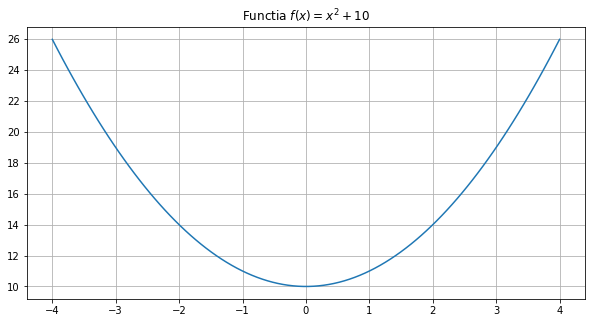

In [2]:
f = lambda x: x * x + 10
grad = lambda x: 2 * x

xf = np.linspace(-4, 4, 100)
yf = f(xf)

def sgd_plot(xf: np.ndarray, 
             yf: np.ndarray, 
             jumps: Optional[np.ndarray]=None, 
             title:str='Functia $f(x)=x^2+10$') -> None:
    _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(xf, yf)
    if jumps is not None:
        ax.plot(jumps, [f(x) for x in res], 'o--')
    ax.set_title(title)
    ax.grid()
    plt.show()

sgd_plot(xf, yf)

Algoritmul SGD presupune ca, intr-un punct dat, sa ne deplasam in directia gradientului negativ cu un factor de scala dat. Acest lucru se face pentru un numar prestabilit de epoci:

In [3]:
def sgd(x: float, eta: float, epochs: int) -> List[float]:
    """
    Aplica SGD pentru functa de cost f. Returneaza lista de valori determinate 
    de SGD. Ar trebui sa se observe o scadere a valorilor functiei de cost.
    
    :param x: punctul din care se porneste cu gradient descent
    :param eta: learning rate
    :param epochs: numarul de iteratii
    
    :return: O lista cu valorile succesive ale lui x, determinate de catre SGD
    """
    
    assert eta > 0
    res = [x] # punctul initial 
    for _ in range(epochs):
        x -= eta * grad(x)
        res.append(x)
    return res

**Optional:** Mai sus functia gradient grad a fost definita manual. Folositi biblioteca [Autograd](https://github.com/HIPS/autograd) pentru a obtine automat gradientul functiei obiectiv definite.

Vom pleca din punctul (-3, 9), cu o rata de invatare $\eta = 0.8$ si vom parcurge 4 epoci:

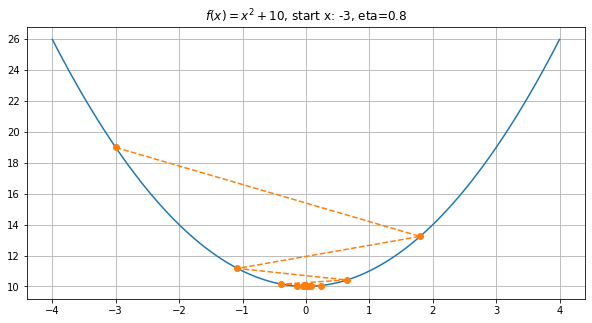

In [22]:
x, eta, epochs = -3, 0.8, 400
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2+10$, start x: {x}, eta={eta}')

Se poate vedea cum traiectoria converge incet catre minimul (0, 10).

a) in cate epoci putem spune ca ajungem la zero?

b) ce se intampla daca plecam din punctul (-2, 14) dar schimbam $\eta = 1.1$?

c) dar daca plecam din punctul (3, 19) dar acum setam $\eta = 1.0$ ?

Realizati graficele pentru cele trei situatii si explicati.

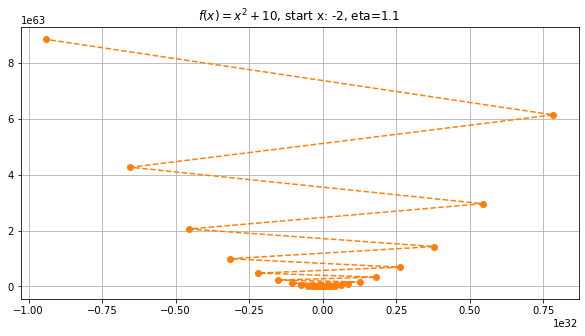

In [36]:
x, eta, epochs = -2, 1.1, 400
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2+10$, start x: {x}, eta={eta}')

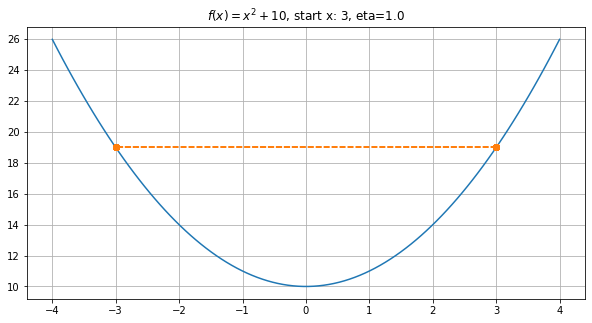

In [34]:
x, eta, epochs = 3, 1.0, 400
res = sgd(x, eta=eta, epochs=epochs)
sgd_plot(xf, yf, res, title=f'$f(x)=x^2+10$, start x: {x}, eta={eta}')

## 1. Setul de date

Vom face aproximarea unei sinusoide printr-un polinom. Coeficientii polinomului se vor determina prin SGD.

In [5]:
# generarea datasetului
xs = np.linspace(0, 3*np.pi, 50)

# initializarea random seed-ului pentru a obtine de fiecare data aceeasi secventa,
# daca se ruleaza de la inceput
np.random.seed(10)
ys = np.sin(xs) + np.random.normal(0, 0.1, len(xs))

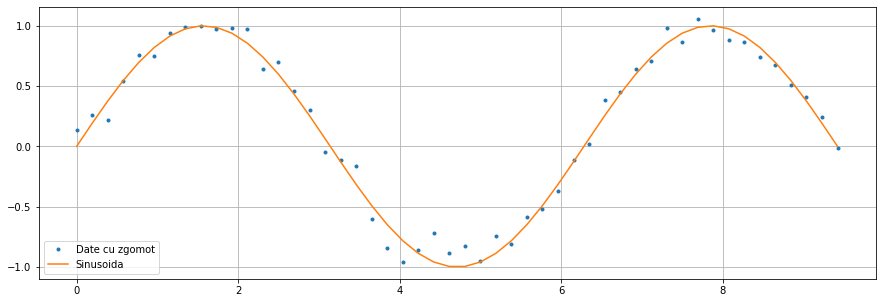

In [6]:
def regr_plot(x: np.ndarray, y1: np.ndarray, y2: np.ndarray) -> None:
    """
    Afisarea graficului a doua functii cu acelasi suport; prima folosind puncte si a doua folosind linii
    
    Args:
        x: valorile peste care se caluleaza functiile
        y1: valorile primei functii
        y2: valorile celei de-a doua functii
    """
    # cream un singur subplot, cu o linie si o coloana, cu dimensiuni specificate
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.plot(x, y1, '.', label='Date cu zgomot')
    ax.plot(x, y2, '-', label='Sinusoida')
    ax.grid()
    ax.legend()
    plt.show()
    
# vom afisa deocamdata setul de puncte pe care vrem sa invatam (xs, ys), precum si functia reala (sinus)
regr_plot(xs, ys, np.sin(xs))

## 2. Crearea trasaturilor polinomiale

Setul de date are deocamdata doar un singur feature ($x$). Vom lua o functie polinomiala de grad $rank$ pentru a aproxima aceasta curba; acea functie este scrisa astfel:
$$func(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_{rank} x^{rank}$$

Vom 'fabrica' featurile corespunzatoare lui $\theta_0$ (aici e simplu, este $x^0 = 1$), $\theta_1 \dots \theta_{rank}$, prin ridicarea la putere a lui $x$. Calculul valorilor functiei pentru toate valorile $x$ se face matricial, astfel:

$$
\left[ \begin{array} \\ func(x_1) \\ func(x_2) \\ \dots \\ func(x_m) \\ \end{array} \right] = 
\left[ \begin{array} \\
1 & x_1 & x_1^2 & \dots & x_1^{rank} \\
1 & x_2 & x_2^2 & \dots & x_2^{rank} \\
\dots & \dots & \dots & \dots & \dots \\
1 & x_m & x_m^2 & \dots & x_m^{rank} \\
\end{array} \right] \cdot
\left[ \begin{array} \\ \theta_1 \\ \theta_2 \\ \dots \\ \theta_{rank} \\ \end{array} \right] = X \theta$$

Putem sa scriem acum functia de loss mai compact astfel:

$$loss(X) = \frac{1}{2m} \|X\theta\ - Y\|^2 = \frac{1}{2} MSE(X\theta - Y)$$

unde bineinteles $Y = \left[ \begin{array} \\ y_1 & y_2 & \dots & y_m \end{array} \right]^T$. Functia anterioara este denumita si Mean Squared Error (MSE).

In [38]:
def expand(xmic, rank):
    """
    Constructia matricii X
    
    Args
        xmic: vector (numpy array) de forma (m,)
        rank: rangul polinomului
        
    Returns
        X calculat va avea m linii si (rank + 1) coloane, iar pe prima coloana vor fi doar 1-uri
    """
    #   TODO, calculati x
#     xmic.reshape(-1, 1)
    x = np.ones((len(xmic), 1))
    
#     for i in range(1, rank + 1):
#         coloana_temporara = xmic.reshape(-1, 1) ** i
#         x = np.hstack((x, coloana_temporara))
    
    x = xmic.reshape(-1, 1) ** np.arange(0, rank + 1)

    # codul de validare de mai jos nu trebuie modificat!

    # dimensiunea lui x
    assert x.shape == (len(xmic), rank+1)
    
    # prima coloana a lui x trebuie sa fie 1
    assert np.all(x[:, 0] == 1.)
    # pentru fiecare din urmatoarele coloane: daca se inmultesc cu xs gasim 
    # valorile din coloana succesoare 
    for col_index in range(1, x.shape[1]-1):
        assert np.allclose(x[:, col_index] * xmic, x[:, col_index+1])
        
    return x

# calcularea lui X, prin generarea puterilor lui xs pe coloane

rank = 3
x = expand(xs, rank)

# primele 4 linii din x
x[:4, :]

array([[1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.19234241, 0.0369956 , 0.00711582],
       [1.        , 0.38468481, 0.14798241, 0.05692658],
       [1.        , 0.57702722, 0.33296042, 0.19212722]])

## 3. Standardizarea setului de date

In [55]:
def normalize(x: np.ndarray) -> np.ndarray:
    """
    Standardizarea pe coloane a lui X. Scopul e sa nu avem feature-uri cu 
    variatii diferite (una foarte putin si alta foarte mult), deoarece modelul 
    va tinde sa le 'potriveasca' doar pe cele cu variatii mari.
    
    Args
        x: matricea de dimensiune m x (rank + 1). Prima coloana se garanteza 
        a fi plina cu 1.
        
    Returns:
        O noua matrice pentru care fiecare coloana va fi o variabila aleatoare 
        de medie 0 si dispersie 1. Prima coloana va ramane 1.  
    """
    _epsilon = 1e-12  # daca diferenta  (in valoare absoluta) dintre doua numere FP este mai mica
    # decat _epsilon, atunci ele se considera egale
    
    # ... TODO ...
    res = x[:,:]
    mean = np.average(x[:,1:], axis=0)
    sigma = np.std(x[:,1:], axis=0)
    for i in range(len(x)):
        res[i,1:] = (res[i,1:]-mean)/sigma
   
    # verificarea faptului ca matricea are coloanele de medie 0 si dispersie 1
    # cu exceptia primeia
    # prima coloana e aproximativ 1
    assert np.allclose(x[:, 0], 1., rtol=_epsilon)
    # media pe coloanele 1, 2 etc. este aproximativ 0
    assert np.allclose(res[:, 1:].mean(axis=0), 0.0, rtol=_epsilon)
    # standard deviation pe coloanele 1, 2 etc, e aproximativ 0
    assert np.allclose(res[:, 1:].std(axis=0), 1, rtol=_epsilon)
    
    return res

x = expand(xs, rank=3)
x_normalized = normalize(x)

## 4. Calculul functiei de loss

Functia polinomiala $func(x) = \theta_0 + \theta_1 x + \theta_2 x^2 + \dots + \theta_{rank} x^{rank}$ se implementeaza sub forma matriciala $func(X) = X \cdot \theta$ :

In [59]:
def func(x: np.ndarray, theta: np.ndarray) -> np.ndarray:
    """
    Calcularea functiei polinomiale
    
    Args:
        x: matricea X cu toate featurile calculate de dimensiune m x (rank + 1)
        
    Returns
        Un vector de dimensiune m reprezentind valoarea polinomului in toate cele m valori x
    """
    # return ... TODO ...

# verificarea implementarii corecte pe un set de coeficienti \theta predeterminat
coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1]), 3)
assert np.all(func(x, coefs) == np.array([2., 2, 4, -2]))

AssertionError: 

Functia de loss este $loss(X) = \frac{1}{2m} \|X \theta - Y\|^2$ si masoara 'cat de departe' este functia polinomiala actuala de valorile $Y$.

In [ ]:
def loss(x: np.ndarray, y:np.ndarray, theta: np.ndarray) -> float:
    """
    Calcularea functiei de loss pentru toate punctele (x, y)
    
    Args:
        x: matricea X a feature-urilor de dimensiune m x (rank + 1)
        y: vectorul iesirilor dorite Y de dimensiune m
        theta: vectorul parametrilor de dimensiune (rank + 1)
        
    Returns
        O valoare scalara ce reprezinta 1/2 MSE(X * theta - Y)
    """
    # pentru norma se poate folosi np.linalg.norm
    # return ... TODO ...

# verificarea sumara a corectitudinii
coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1, -2]), 3)
assert loss(x, np.array([2., 2, 4, -2, -16]), coefs) == 0.

Pentru functia $loss(X) = \frac{1}{2m} \|X \theta - Y\|^2$, gradientul in raport cu directia $\theta$ se calculeaza astfel:

$$grad(X, theta) = \nabla_{\theta} loss(X) = \frac{1}{m} X^T (X \theta - Y)$$

In [ ]:
def grad(x, y, theta, lmbda=0):
    """
    Calculul gradientului dupa directia theta in punctul X
    
    Args:
        x: matricea X a feature-urilor, de dimensiune m x (rank + 1) 
        y: vectorul Y de dimensiune m
        theta: vectorul parametrilor de dimensiune (rank + 1)
        lmbda: parametrul de regularizare (optional)
        
    Returns:
        gradientii pentru toate punctele x, vector de dimensiune m
        
    Observatii
        * initial nu implementati regularizarea (factorul lambda)
        * pentru implementarea cu lambda, atentie la \theta_0 (vedeti cursul)
    """
    res = 1.0 / x.shape[0] * x.T @ (x@theta-y)
    return res

coefs = np.array([2., 1., -2, 1])
x = expand(np.array([0., 1, 2, -1, -2]), 3)
y = np.array([2., 2, 4, -2, -16])
assert np.all(grad(x, y, coefs) == np.array([0.] * 4))

'Antrenarea' parametrilor nu este altceva decat minimizarea repetata a functiei de loss, prin avansul parametrilor $\theta$ in directia gradientului negativ.

Functia de antrenare (train) va itera un numar de epoci, iar la fiecare epoca parametrul $\theta$ se va modifica:

$$\theta \leftarrow \theta - \eta \cdot grad(X, Y, \theta)$$

1. La fiecare epoca sa ia intregil set de date: ignoram parametrul batch si actualizam gradientul la fiecare epoca, pe tot setul de date

2. Dupa ce verificam functionalitatea pe punctul 1, implementam si versiunea batch gradient descent: dupa fiecare batch (aici = 10) samples, actualizam coeficientii $\theta$. Nu parcurgeti din 10 in 10, ci la fiecare epoca amestecati indicii liniilor lui x, astfel incat cele 10 sample-uri dupa care faceti update-ul lui $\theta$ sa fie amestecate.

    De exemplu, daca am avea un numar de 12 sample-uri in total si un batch de dimensiune 3, o ordonare trine-amestecata pe batch-uri ar fi:
    batch1 = (0, 1, 2) 
    batch2 = (3, 4, 5)
    batch3 = (6, 7, 8)
    batch4 = (9, 10, 11)
    
    O ordonare stochastica (aleatoare) ar putea arata astfel (ceea ce trebuie sa implementati):
    batch1 = (2, 10, 4) 
    batch2 = (1, 11, 6)
    batch3 = (7, 3, 8)
    batch4 = (9, 0, 5)
    
    Versiunea batch stochastic gradient ar trebui sa va conduca la un loss final mai redus.
    
    
## 5. Antrenarea folosind gradient descent

In [ ]:
# pentru punctul 1: batch = intregul set de date
def train(xs, ys, rank=3, eta=0.1, epochs=20, batch=10, lmbda=0.):
    """
    Procedura de antrenare, de minizimare a coeficientilor functiei polinomiale
    
    Args:
        xs: feature-urile X, de dimensiune m x (rank + 1)
        ys: valorile Y, vector de dimensiune m
        rank: gradul polinomului
        eta: denumit si rata de invatare (learning rate); o valoare buna la inceput este 0.1 (o zecime)
        epochs: numarul de epoci
        batch: dimensiunea unui batch
        lmbda: regularization lambda
        
    Returns:
        tupla de 3 elemente: X-ul normalizat, theta initial si theta antrenat
    """
    x = expand(xs, rank)
    assert x.shape[0] == len(xs)
    assert x.shape[1] == rank + 1
    
    coefs = np.random.normal(size=rank + 1)
    coefs_init = coefs.copy()
    assert len(coefs) == rank + 1

    x = normalize(x)
    
    print(f'initial loss: {loss(x, ys, coefs)}')
    for epoch in range(epochs):
        # ... TODO ...
        print(f'loss on epoch {epoch}: {loss(x, ys, coefs)}')
    
    return x, coefs, coefs_init

In [ ]:
# pentru punctul 2: minibatches

In [ ]:
# impunem o anume alegere aleatorie, pentru repetabilitate
np.random.seed(11)

# antrenam modelul
x, coefs, coefs_init = train(xs, ys, rank=50, eta=0.001, epochs=100000)

# asa arata regresia cu coeficientii luati initial aleator
regr_plot(xs, ys, func(x, coefs_init))

In [ ]:
# asa arata regresia cu coeficientii antrenati
regr_plot(xs, ys, func(x, coefs))
loss(x, ys, coefs) # loss-ul trebuie sa fie undeva la 0.03, sau mai putin pentru varianta cu antrenare pe tot batch-ul la fiecare epoca

## 6. Calcul direct folosid ecuatiile normale

Cazul regresiei liniare este un caz fericit, pentru ca avem o solutie analitica pentru $\theta$:

$$\theta = (X^T X)^{-1} X^T Y$$

Investigati functia `np.linalg.pinv` pentru o implementare eficienta.

In [ ]:
# calculam solutia analitic
# theta = ... TODO ...

# afisam comparativ solutia analitica si calculam loss-ul asociat
regr_plot(xs, ys, func(x, theta))
loss(x, ys, theta) # loss-ul este in jurul lui 0.002

## 7.1 Regularizarea



Pentru acest exemplu, este destul de dificil de vazut efectul regularizarii pentru algoritmul SGD (necesita multi pasi de antrenare). Efectul se poate vedea bine insa pentru calculul direct folosind ecuatia caracteristica, in care am introdus termenul de regularizare:

$$\theta = (X^T X + 2 \lambda I_{rank+1})^{-1} X^T Y$$

Vom urmari, pe langa reprezentarea grafica a regresiei polinomiale, care este loss-ul pentru setul de date X precum si suma valorilor absolute ale coeficientilor, $\sum_i |\theta_i|$. Scopul regularizarii este sa avem coeficienti de valori cat mai mici; aceasta deoarece la o valoare mare a unui coeficient $\theta_i$, o variatie mica a feature-ului corespunzator $x_i$ se traduce intr-o variatie foarte mare a functiei polinomiale - overfitting. Vrem sa evitam acest lucru.

In [ ]:
lmbda = 0.000
#theta0 = ... TODO ... 
lmbda = 0.001
#theta1 = ... TODO ... (acelasi lucru, doar cu alti coeficienti)

In [ ]:
regr_plot(xs, ys, func(x, theta0))
print(f'loss(x, ys, theta0): {loss(x, ys, theta0)}, sum(theta0) {np.abs(theta0).sum()}')
regr_plot(xs, ys, func(x, theta1))
print(f'loss(x, ys, theta1): {loss(x, ys, theta1)}, sum(theta1) {np.abs(theta1).sum()}')

Pentru figura de mai sus. observati cum odata cu regularizarea, loss-ul a scazut de la 0.6 la 0.008 iar suma coeficientilor de la peste 100 milioane la sub 100.

## 7.2 Regularizarea folosind modelele sklearn

Modelele de regresie liniara sunt implementate in bibiloteca SciKit Learn:
https://scikit-learn.org/stable/modules/linear_model.html

Le vom folosi pentru a realiza cat de importanta este regularizarea parametrilor modelului.

In primul exemplu, vom folosi modelul de regresie liniara simpla, fara regularizare:

$$min_{\theta} \|X \theta - Y\|^2$$

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

rank = 50
x = expand(xs, rank)
assert x.shape[0] == len(xs)
assert x.shape[1] == rank + 1

linreg = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

linreg.fit(x, ys)
y_pred = linreg.predict(x)

In [ ]:
regr_plot(xs, ys, y_pred)
print(f'loss: {np.sum((ys - y_pred) ** 2)}, sum(theta): {np.abs(linreg["linearregression"].coef_).sum()}')

Functia de loss cu regularizare este:

$$min_{\theta} \|X \theta - Y\|^2 + \lambda \|\theta\|^2$$

Acest tip de regresie cu regularizare se numeste Ridge Regression:

In [ ]:
linreg =  make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=1e-9))
linreg.fit(x, ys)
y_pred = linreg.predict(x)

In [ ]:
regr_plot(xs, ys, y_pred)
print(f'loss: {np.sum((ys - y_pred) ** 2)}, sum(theta): {np.abs(linreg["ridge"].coef_).sum()}')

Observati cum desi loss-ul a ramas in acelasi ordin de marime, suma valorilor absolute ale coeficientilor a scazut drastic; asta inseamna ca acei coeficienti sunt constransi acum sa ia valori mici, apropiate de zero.

In [ ]:
lmbda = [1., 0.1, 0.01, 0.001, 0.0001, 1e-4, 1e-8]
y_res = []
for a in lmbda:
    linreg = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=a))
    linreg.fit(x, ys)
    y_pred = linreg.predict(x)
    y_res.append(y_pred)

In [ ]:
# modificati codul de mai jos in asa fel incat pentru fiecare varianta (coeficent de regularizare) sa afisati
# si loss-ul, respectiv suma valorii absolute a coeficientilor (2 zecimale)
# ... TODO ...
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
for i in range(len(y_res)):
    ax[i//4, i % 4].plot(xs, ys, '.')
    ax[i//4, i % 4].plot(xs, y_res[i], '-')
    ax[i//4, i % 4].grid()
    
    ax[i//4, i % 4].set_title(f'$\lambda$: {lmbda[i]}')
plt.show()